In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import itertools
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import datasets
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

In [3]:
%matplotlib inline

In [4]:
from contour_visualization.Gaussian import Gaussian
from contour_visualization import picture_plot

from gmm_dimension_reduction.slicing import slice_gmm
from gmm_dimension_reduction import GaussianMixtureModel

contour_visualization.picture_contours - WARNING - No module named 'density_visualization'
No module named 'mb_modelbase'


In [5]:
def normalize_df(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=df.columns)

In [6]:
def _read(file):
    df = pd.read_csv(file)
    df = pd.DataFrame(df, columns=['trans', 'cyl', 'T', 'class', 'year', 'cty', 'hwy', 'displ'])
    df = df.rename(columns={'cty': 'mpg_city', 'hwy': 'mpg_highway', 'trans': 'transmission',
                            'T': 'turbo', 'cyl': 'cylinder', 'class': 'car_size', 'displ': 'displacement'})
    return df

def cg_4cat3cont(file, do_not_change=[]):
    df = _read(file)
    df = pd.DataFrame(df, columns=['transmission', 'cylinder', 'turbo', 'car_size', 'year', 'mpg_city', 'mpg_highway', 'displacement'])

    df.car_size.replace(to_replace={'pickup': 'large', 'suv': 'midsize', 'station wagon': 'midsize',
                                     'compact': 'small', 'passenger van': 'large', 'cargo van': 'large', 'two seater': 'small', 'large car': 'large', 'midsize car': 'midsize', 'compact car': 'small'}, inplace=True)

    if 'cylinder' not in do_not_change:
        df.cylinder.replace(to_replace={2: 'few', 3: 'few', 4: 'few', 5: 'medium', 6: 'medium',
                                        7: 'medium', 8: 'medium', 10: 'many', 12: 'many', 16: 'many'}, inplace=True)

    df.replace(to_replace={'transmission': {
        '.*auto.*': 'auto'}}, inplace=True, regex=True)
    
    df.replace(to_replace={'transmission': {
        'lock-up.*': 'lock-up'}}, inplace=True, regex=True)
    
    df.replace(to_replace={'transmission': {
        'manual.*': 'manual'}}, inplace=True, regex=True)
    
    df = df.drop(df[df.transmission == 'semi-auto'].index)
    df = df.drop(df[df.transmission == 'creeper(C5)'].index)
    df = df.drop(df[df.car_size == 'spv'].index)
    df = df.dropna(axis=0)
    df.reset_index(drop=True, inplace=True)

    for col in ['transmission', 'cylinder', 'turbo', 'car_size']:
        df[col] = df[col].astype('str')

    del df['turbo']

    return df

## Weather australia (2018 - 2020)

In [7]:
def data_weather_australia2018_2020():

    df = pd.read_csv("../mixture_model_data/marginalization/predicting_rain/own_3_data.csv")

    col_del = ["Day(Local_Date)", "Station", "Pstn(hPa)", "ET05(C)", "ET10(C)", "ET20(C)", "ET30(C)", "ET100(C)", "Tgmin(C)", "Pmsl(hPa)", "Rad(MJ/m2)"]
    for i in col_del:
        del df[i]

    for i in df.columns:
        df = df[df[i] != "-"]

    df = df.astype("float")

    columns= {
            "WDir(Deg)": "Wind Direction",
            "WSpd(m/s)": "Wind Speed",
            "Tmax(C)": "Max Temp",
            "Tmin(C)": "Min Temp",
            "RH(%)": "Rel. Humidity",
            "Sun(Hrs)": "Sun Hours",
        }

    df = df.rename(columns, axis='columns')
    return df

Ich weiß nicht was das folgende einmal gemacht hat:

    "Wind Direction", , "Rel. Humidity", "Sun Hours"

    #%%

    columns_merge = ["Max Temp", "Min Temp", "Sun Hours"]

    #%%

    df_merge = pd.merge(df, df_aust, on=columns_merge, how='inner')
    df_merge

    #%%

    df1

    #%%

    df1['Duplicated'] = df1.duplicated(keep=False) # keep=False marks the duplicated row with a True
    df_final = df1[~df1['Duplicated']] # selects only rows which are not duplicated.
    del df_final['Duplicated'] # delete the indicator column

    #%%

    df_final


## Weather Australia

This is the data set that we finally use in the paper and the appendix.

In [8]:
def data_weather_australia():
    df = pd.read_csv("../mixture_model_data/marginalization/predicting_rain/SPLOM_weather.csv")
    df = df[df['Rel. Humidity'] != "-"]
    df["Rel. Humidity"].unique()
    df = df.astype({"Rel. Humidity": "float"})
    df = normalize_df(df)
    print(df.head())
    return df


## Weather germany

In [9]:
def data_weather_germany():
    df = pd.read_csv("predicting_rain/recent_daily_weather_data_cleaned.csv", header=0)
    df = df.dropna()
    df[df.columns[4:]]
    df = normalize_df(df[df.columns[4:]])
    return df

In [10]:
def slicing_plot_matrix(data, n_components=3, show_axes=False, **kwargs):

    # https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
    _, numvars = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    gm = GaussianMixture(n_components=n_components, random_state=0).fit(data)

    # Plot the data.
    for i, j in tqdm(zip(*np.triu_indices_from(axes, k=1))):
        for x, y in [(i, j), (j, i)]:
            create_gmm_plot(axes[x, y], gm, data, [x, y], **kwargs)

    names = data.columns
    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i, i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                            ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    if show_axes:
        for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
            axes[j, i].xaxis.set_visible(True)
            axes[i, j].yaxis.set_visible(True)
    return fig

In [11]:
def __get_range(min_value, max_value, margin=0.1):
    return (max_value - min_value) * margin

def create_gmm_plot(ax, gm, df, features, size=200, show_points=False, *args, **kwargs):
    margin=0.3
    extends = [
        (min(df.min()) - __get_range(min(df.min()), max(df.max()), margin),
         max(df.max()) + __get_range(min(df.min()), max(df.max()), margin)),
        (min(df.min()) - __get_range(min(df.min()), max(df.max()), margin),
         max(df.max()) + __get_range(min(df.min()), max(df.max()), margin))
    ]
    #     extends = [
    #         (point.min() - __get_range(point.min(), point.max()),
    #          point.max() + __get_range(point.min(), point.max()))
    #         for point in [df[df.columns[features]].iloc[:, 0], df.iloc[:, 1]]
    #     ]
    weights_, means_, covariances_ = slice_gmm(features, gm.weights_, gm.means_, gm.covariances_)
    gmm = [Gaussian(weight=weights ,means=means , cov_matrix=covariances, size=size) for weights, means, covariances in zip(weights_, means_, covariances_)]
    picture_plot.plot_image(ax, gmm, xlim=extends[0], ylim=extends[1], *args, **kwargs)
    if show_points == True:
        ax.scatter(df[df.columns[features[1]]], df[df.columns[features[0]]], s=10**-2)
#     picture_plot.plot_image(ax, gmm, *args, **kwargs)
    

In [12]:
def double_scatterplot_matrix(data, lower_params, upper_params=None, n_components=3, show_axes=False, **kwargs):
    if lower_params and not upper_params:
        upper_params = lower_params
    # https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib
    _, numvars = data.shape
    fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.03, wspace=0.03)

    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')

    gm = GaussianMixture(n_components=n_components, random_state=0).fit(data)

    # Plot the data.
    for i, j in tqdm(zip(*np.triu_indices_from(axes, k=1))):
        create_gmm_plot(axes[j, i], gm, data, [i, j], **lower_params, **kwargs)
        create_gmm_plot(axes[i, j], gm, data, [i, j], **upper_params, **kwargs)
        # for x, y in [(i, j), (j, i)]:
        #     if x > y:
        #         create_gmm_plot(axes[x, y], gm, data, [x, y], **lower_params, **kwargs)
        #     else:
        #         create_gmm_plot(axes[x, y], gm, data, [x, y], **upper_params, **kwargs)

    names = data.columns
    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i, i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                            ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    if show_axes:
        for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
            axes[j, i].xaxis.set_visible(True)
            axes[i, j].yaxis.set_visible(True)
    return fig

# load data

In [13]:
df = data_weather_australia().iloc[:,:5]
df = normalize_df(df) #[df.columns[:5]]
df.head()
#df.columns = ["Tmax(C)", "Tmin(C)", "WDir(Deg)", "WSpd(m/s)", "Sun(Hrs)"]

   Max Temp  Min Temp  Wind Direction  Wind Speed  Sun Hours  Rel. Humidity  \
0  0.598930  0.543379        0.771588    0.065455   0.950000       0.500000   
1  0.711230  0.694064        0.543175    0.189091   0.950000       0.500000   
2  0.679144  0.643836        0.746518    0.058182   0.542857       0.661290   
3  0.877005  0.721461        0.579387    0.136364   0.950000       0.612903   
4  0.737968  0.648402        0.830084    0.065455   0.628571       0.532258   

   Rain Amount  Outcome  
0          0.0      0.0  
1          0.0      0.0  
2          0.0      0.0  
3          0.0      0.0  
4          0.0      0.0  


,Max Temp,Min Temp,Wind Direction,Wind Speed,Sun Hours
0,0.598930,0.543379,0.771588,0.065455,0.950000
1,0.711230,0.694064,0.543175,0.189091,0.950000
2,0.679144,0.643836,0.746518,0.058182,0.542857
3,0.877005,0.721461,0.579387,0.136364,0.950000
4,0.737968,0.648402,0.830084,0.065455,0.628571


# settings


In [14]:
save_path  = os.path.abspath('/home/luca_ph/Documents/papers_aktuelle/eurovis2022-GMM/figures_new')

plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams['savefig.format'] = 'png'

size=500

dist_params = {
    "scatter_points": True,
    "scatter_points_num": int(600**0.5),
}

vis_params = {
    # "xlim": [-7.5,12.5],
    # "ylim": [-10. , 10],
    #"xlim": [-10,15],
    #"ylim": [-12.5 , 12.5],
    "marker": "o",
    "edge_colors": False,
    "face_colors": True,
    "alpha": 0.6,  # opacity
    "s":  1.2**2, # size
}

In [15]:
pie_params = {
    "pie_charts": True,
    "pie_num": 20,
    "pie_angle": 90,
    "pie_chart_iso_level": 40,
    "pie_chart_contour_method": "equal_density",
    "pie_chart_modus": "light"
}

In [16]:
contour_params = {
    "contours": True,
    "contour_lines": True
}

In [17]:
scatter_params = dist_params.copy()
scatter_params.update(vis_params)

In [18]:
cross_params = {
    "crosses": True,
    "contour_lines": True
}

# test visualizations

In [19]:
df.head()

,Max Temp,Min Temp,Wind Direction,Wind Speed,Sun Hours
0,0.598930,0.543379,0.771588,0.065455,0.950000
1,0.711230,0.694064,0.543175,0.189091,0.950000
2,0.679144,0.643836,0.746518,0.058182,0.542857
3,0.877005,0.721461,0.579387,0.136364,0.950000
4,0.737968,0.648402,0.830084,0.065455,0.628571


In [20]:
size=20

10it [00:58,  5.87s/it]


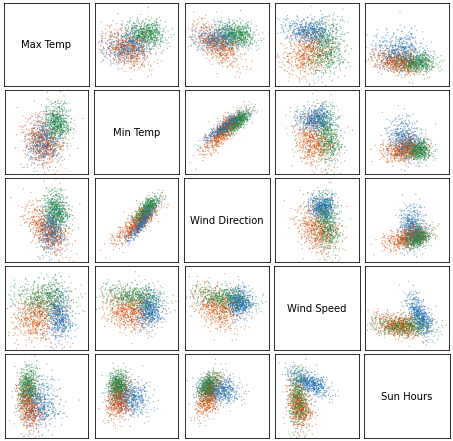

In [21]:
# testing the slicing plot matrix
fig = slicing_plot_matrix(df, **dist_params, **vis_params)

10it [00:31,  3.17s/it]


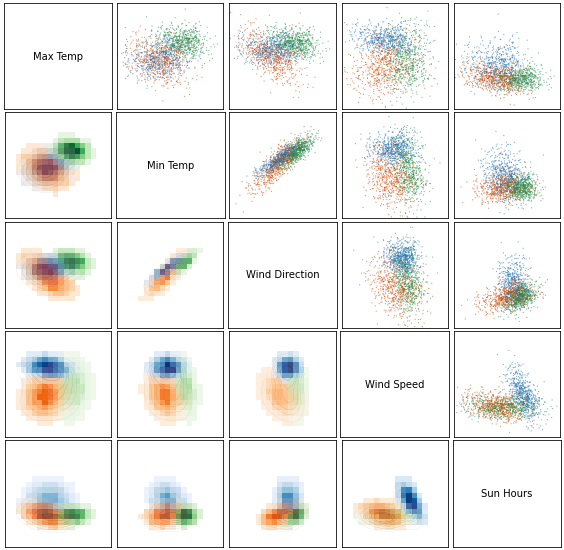

In [22]:
# testing the double plot matrix
fig = double_scatterplot_matrix(df[df.columns],
                               contour_params,
                               scatter_params,
                               size=size, linewidth=.1)

1it [00:03,  3.26s/it]


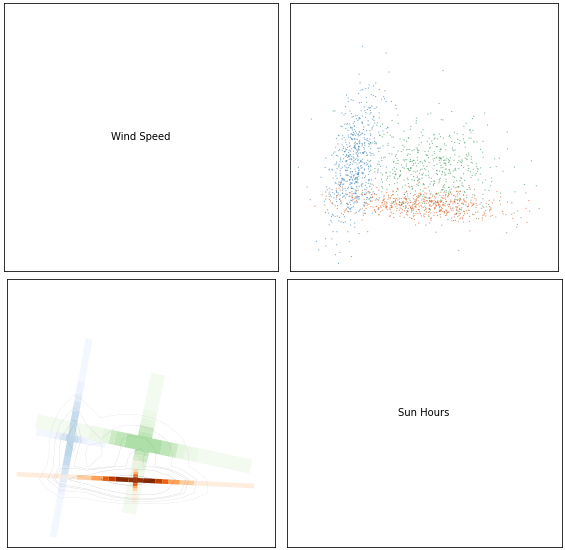

In [23]:
fig = double_scatterplot_matrix(df[df.columns[3:5]],
                               cross_params,
                               scatter_params,
                               size=size, linewidth=.1)

1it [00:03,  3.63s/it]


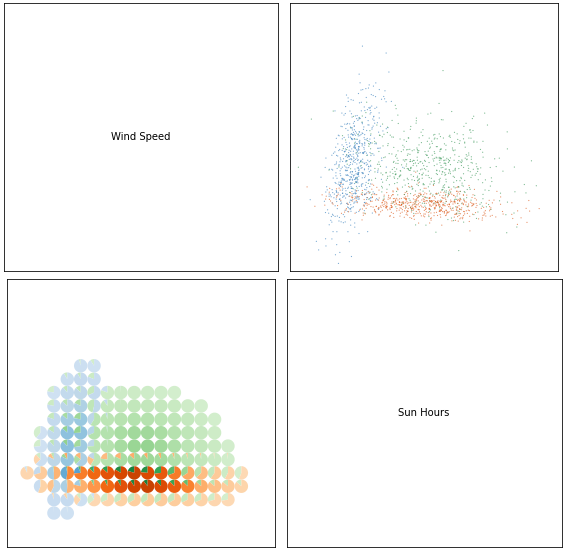

In [24]:
fig = double_scatterplot_matrix(df[df.columns[3:5]],
                               pie_params,
                               scatter_params,
                               size=size, linewidth=.1)

# Paper Visualizations

## combined plot matrices

In [25]:
size=500

In [26]:
parameterSets = list(zip(['contour', 'cross', 'sampling', 'pie'],
                         [contour_params, cross_params, scatter_params, pie_params]))

generating weatherdata_contour_cross ... 


5it [01:26, 17.21s/it]points in grid of z-coordinates too similar
6it [01:43, 17.24s/it]points in grid of z-coordinates too similar
9it [02:34, 17.14s/it]points in grid of z-coordinates too similar
10it [02:51, 17.18s/it]


saving figure for weatherdata_contour_cross ... 
... done
generating weatherdata_contour_sampling ... 


10it [03:13, 19.36s/it]


saving figure for weatherdata_contour_sampling ... 
... done
generating weatherdata_contour_pie ... 


10it [02:44, 16.50s/it]


saving figure for weatherdata_contour_pie ... 
... done
generating weatherdata_cross_sampling ... 


5it [00:26,  5.16s/it]points in grid of z-coordinates too similar
6it [00:31,  5.32s/it]points in grid of z-coordinates too similar
9it [00:46,  4.99s/it]points in grid of z-coordinates too similar
10it [00:51,  5.12s/it]


saving figure for weatherdata_cross_sampling ... 
... done
generating weatherdata_cross_pie ... 


5it [00:12,  2.41s/it]points in grid of z-coordinates too similar
6it [00:15,  2.41s/it]points in grid of z-coordinates too similar
9it [00:22,  2.38s/it]points in grid of z-coordinates too similar
10it [00:24,  2.49s/it]


saving figure for weatherdata_cross_pie ... 
... done
generating weatherdata_sampling_pie ... 


10it [00:45,  4.56s/it]


saving figure for weatherdata_sampling_pie ... 
... done


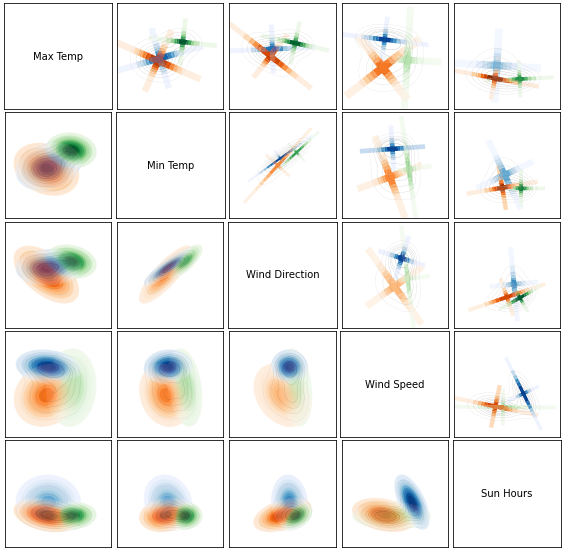

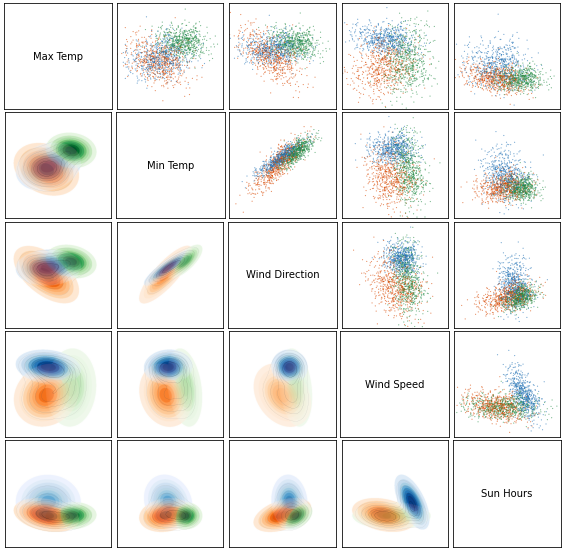

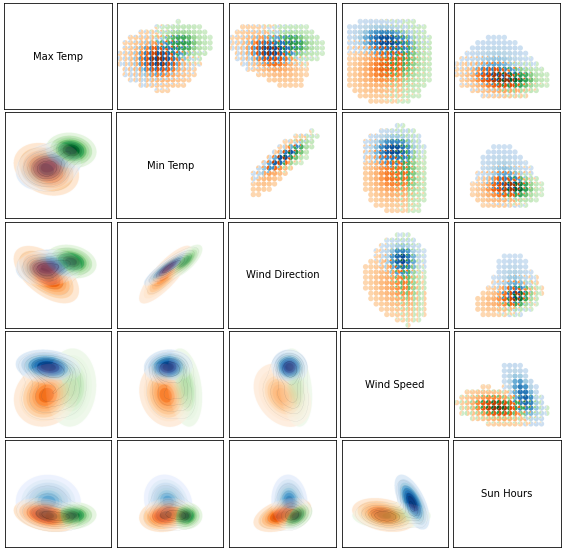

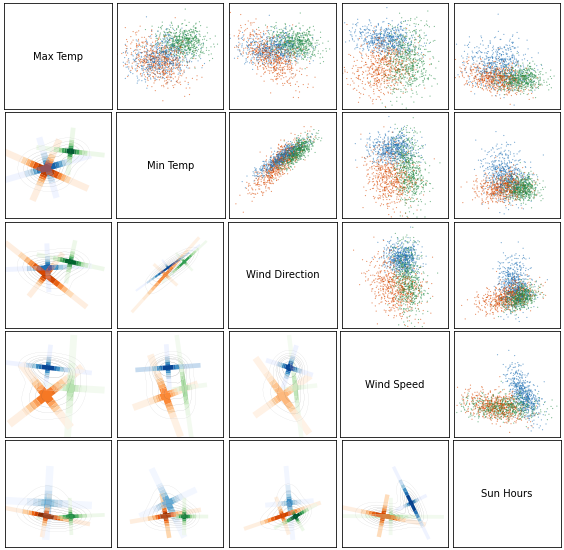

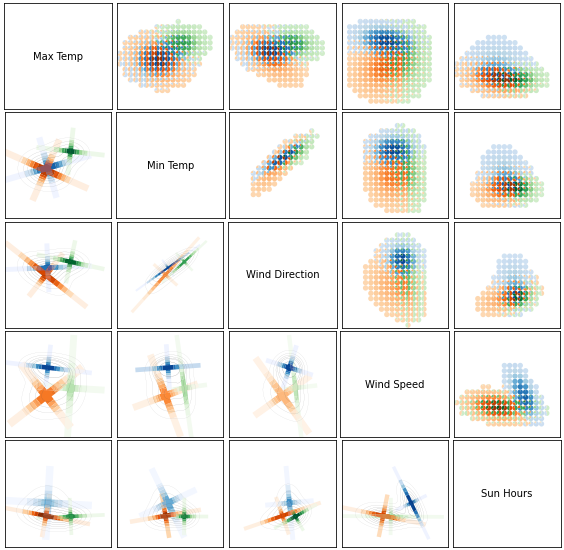

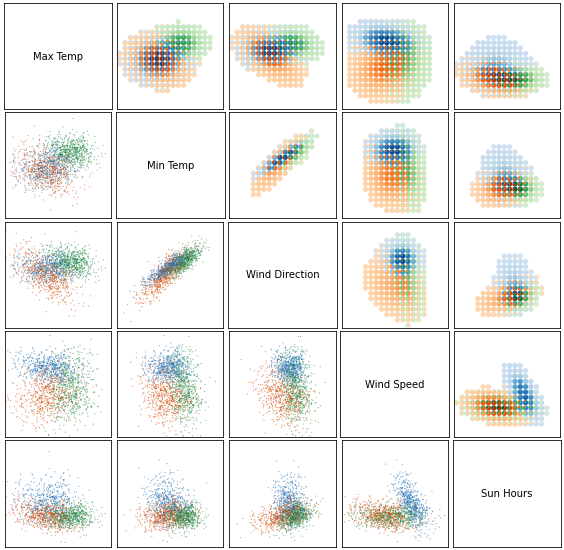

In [27]:
for idx1, (name1, params1) in enumerate(parameterSets):
    for idx2, (name2, params2) in enumerate(parameterSets):
        if idx1 < idx2 and name1 != name2:
            print(f'generating weatherdata_{name1}_{name2} ... ')
            fig = double_scatterplot_matrix(df,
                                            params1,
                                            params2,
                                            size=size, linewidth=.1)
            print(f'saving figure for weatherdata_{name1}_{name2} ... ')
            fig.savefig(os.path.join(save_path, f'weatherdata_{name1}_{name2}.png'))
            fig.savefig(os.path.join(save_path, f'weatherdata_{name1}_{name2}.pdf'), format='pdf')
            print(f'... done')

## single design matrices

In [28]:
size=500

generating weatherdata_contour ... 


10it [05:14, 31.47s/it]


saving figure for weatherdata_contour ... 
... done
generating weatherdata_cross ... 


5it [00:14,  2.86s/it]points in grid of z-coordinates too similar
points in grid of z-coordinates too similar
6it [00:17,  2.81s/it]points in grid of z-coordinates too similar
points in grid of z-coordinates too similar
9it [00:25,  2.82s/it]points in grid of z-coordinates too similar
points in grid of z-coordinates too similar
10it [00:28,  2.89s/it]


saving figure for weatherdata_cross ... 
... done
generating weatherdata_sampling ... 


10it [01:09,  6.93s/it]


saving figure for weatherdata_sampling ... 
... done
generating weatherdata_pie ... 


10it [00:19,  1.95s/it]


saving figure for weatherdata_pie ... 
... done


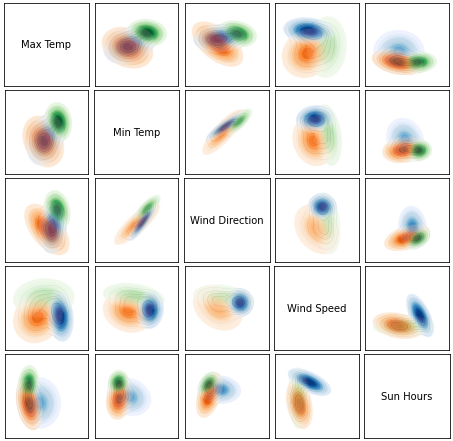

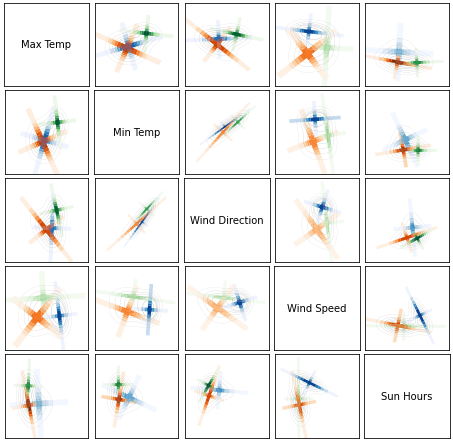

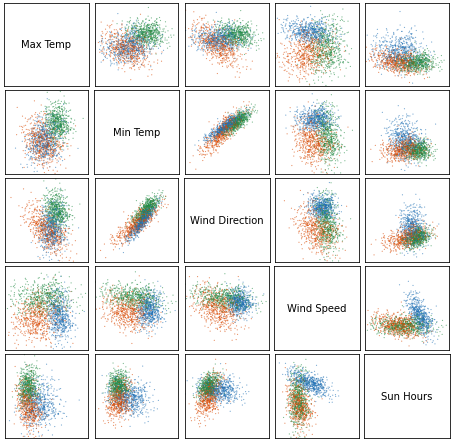

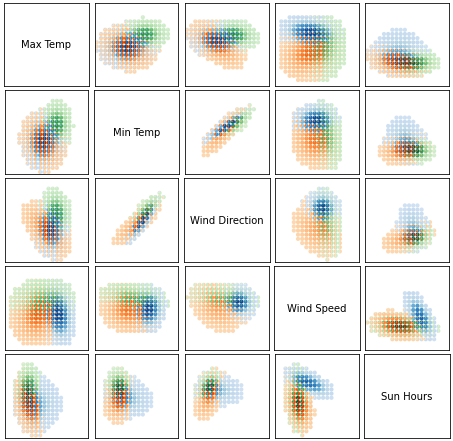

In [29]:
for name, params in parameterSets:
     print(f'generating weatherdata_{name} ... ')
     fig = slicing_plot_matrix(df, **params, size=size, linewidth=.1)
     print(f'saving figure for weatherdata_{name} ... ')
     fig.savefig(os.path.join(save_path, f'weatherdata_{name}.png'))
     fig.savefig(os.path.join(save_path, f'weatherdata_{name}.pdf'), format='pdf')
     print(f'... done')

10it [00:14,  1.47s/it]


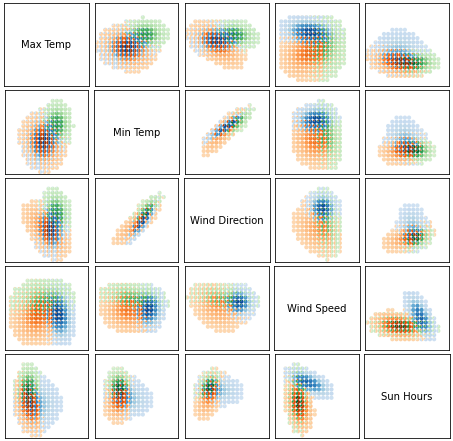

In [30]:
fig_pie = slicing_plot_matrix(df[df.columns], pie_charts=True, pie_num = 20, pie_angle=90, pie_chart_iso_level=40, pie_chart_contour_method="equal_density", pie_chart_modus="light")

In [31]:
fig_pie.savefig(os.path.join(save_path, f'weatherdata_pie2.png'))

10it [05:07, 30.76s/it]


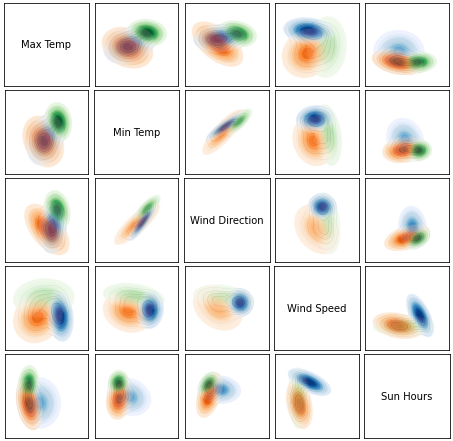

In [32]:
fig_contours = slicing_plot_matrix(df[df.columns[:5]], contours=True, contour_lines=True, size=size, linewidth=.1)

In [33]:
fig_contours.savefig(os.path.join(save_path, f'weatherdata_contour2.png'))

5it [00:05,  1.00s/it]points in grid of z-coordinates too similar
points in grid of z-coordinates too similar
6it [00:06,  1.02it/s]points in grid of z-coordinates too similar
points in grid of z-coordinates too similar
9it [00:09,  1.03it/s]points in grid of z-coordinates too similar
points in grid of z-coordinates too similar
10it [00:10,  1.02s/it]


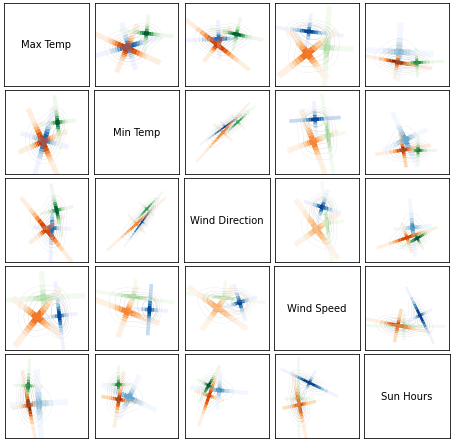

In [34]:
fig_crosses = slicing_plot_matrix(df[df.columns[:5]], crosses=True, contour_lines=True, linewidth=.1)

In [35]:
fig_crosses.savefig(os.path.join(save_path, f'weatherdata_crosses2.png'))
